# Content-Based Recommendation of Songs from Spotify


### Dataset

The dataset is from the Kaggle competition (Download Link: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). It contains ~ 500 k tracks from Spotify with audio features and additional information and ~ 1 mio. artists with genre and additional information.

You can find an explanation of the Spotify audio features here: https://hexdocs.pm/spotify_web_api/Spotify.AudioFeatures.html

### Project: Recommend Tracks from Spotify based on User Input

#### Content
* load, clean and explore data
* train and optimize k-means using numerical features from the dataset
* implement a content-based recommendation system for songs with the help of the clustering model
* apply and test the system with (manually generated) examplary user input

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

import time

## Load data

### Dataset Description
* **tracks:** list of tracks from artists including audio features and other information (e.g. popularity)
* **artists:** list of artists (can be X feat. Y) including followers and popularity
* **dict_artists:** there is also a dictionary containing relations of artists but I won't use it for the project

In [2]:
# audio features of tracks, 600k rows
tracks = pd.read_csv('data/tracks.csv')
print('Shape tracks dataset: ', tracks.shape)
tracks.head() 

Shape tracks dataset:  (586672, 20)


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [3]:
# popularity metrics of artists, 1.1M rows
artists = pd.read_csv('data/artists.csv') 
print('Shape artists dataset: ', artists.shape)
artists.head()

Shape artists dataset:  (1104349, 5)


,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


## Data Cleaning / Preparation
* There are a number of columns which are represented as string object but are actually lists. It is inconvenient to work with lists as values in a pandas DF, so for the most parts, I will leave it as string and create helper DFs to look into the 'list' columns.
* adjust data types
* check for missing values

In [4]:
def col_to_list(df, column):
    ''' Columns that consist of strings but are
    actually lists are converted to lists.
    
    INPUT:
    df - dataframe with string column
    column - column with strings
    
    OUTPUT:
    new dataframe with list column
    
    '''
    tr_df = df.copy()
    tr_df[column] = tr_df[column].str.replace(r"[\[''\]]", "", regex=True)
    tr_df[column] = tr_df[column].str.split(",")
    return tr_df

In [5]:
tracks.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

In [6]:
tracks['release_date'] = pd.to_datetime(tracks['release_date'], infer_datetime_format=True, errors='raise')

In [7]:
# if name and artists match, only keep first appearance
tracks = tracks.drop_duplicates(subset=['name', 'artists'])

In [8]:
artists.dtypes

id             object
followers     float64
genres         object
name           object
popularity      int64
dtype: object

In [9]:
artists = artists.drop_duplicates(subset='name')

In [10]:
artists.shape[0]

1078660

### Create helper dataframes

In [11]:
# create df to count artists
tr_tracks = col_to_list(tracks, 'artists')
tr_tracks = tr_tracks.explode('artists')
# remove trailing whitespaces
tr_tracks['artists'] = tr_tracks['artists'].str.strip() 

In [12]:
# artists with transformed genres column
tr_artists = col_to_list(artists, 'genres')
tr_artists = tr_artists.explode('genres')
# remove trailing whitespaces
tr_artists['genres'] = tr_artists['genres'].str.strip()

#### Merge Artists and Tracks Tables
Since a track can be from several artists (up to 58), we need to explode the artists column from a list to single rows and group and aggregate them afterwards to get the list view again.

In [13]:
def flatten_list(l):
    ''' Flatten a 2D list to a 1D list
    
    INPUT: 
    l - 2D list
    
    OUPUT:
    1D list
    '''
    flat_list = [] 
    for sub in l:
        # nan is float type, ignore and do not add to list
        # so that e.g. [nan] becomes an empty list []
        if isinstance(sub, float):
            continue
        for j in sub:
            flat_list.append(j)

    return flat_list        

In [14]:
# explode artists ids from tracks part dataset 
tracks_part = tracks.loc[:, ['id', 'artists', 'id_artists']]
tracks_part = col_to_list(tracks_part, 'id_artists')
tracks_part = tracks_part.explode('id_artists')

In [15]:
# merge tracks part list and artists datasets
merged_tracks = tracks_part.merge(artists[['id', 'followers', 'genres']], how='left', left_on='id_artists',
                                 right_on='id')
merged_tracks = merged_tracks.drop('id_y', axis=1)
merged_tracks = merged_tracks.rename({'id_x': 'id'}, axis='columns')
merged_tracks = col_to_list(merged_tracks, 'genres')

In [16]:
# to "un-explode" the DF again, make list of artist ids, genres and followers so that we end up with 1 line per track id
list_merge = merged_tracks[['id', 'id_artists', 'followers', 'genres']].groupby(
                                                                         ['id'], 
                                                                         as_index=False).aggregate(lambda x: list(x))

In [17]:
# flatten lists from 2d to 1D
list_merge['genres'] = list_merge['genres'].apply(flatten_list)

In [18]:
# merge with "full" tracks dataset
tmp_tracks = tracks.drop('id_artists', axis=1)
merged_df = pd.merge(list_merge, tmp_tracks, on=['id', 'id'])

### Missing Values

In [19]:
def cols_all_nan(df):
    ''' Returns columns with NaN for every row in df
    
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    list of column indices for all columns with all NaN values 
    '''
    return df.columns[df.isnull().all()]

In [20]:
def cols_with_nan(df, percentage):
    '''Returns the column names that have more than (percentage * 100) %
    of their values missing
    
    INPUT:
    df - pandas dataframe
    percentage - float, percentage of values missing

    OUTPUT:
    list of column indices for all columns where more than (percentage * 100) %
    of their values are missing
    '''
    return df.columns[np.sum(df.isnull())/df.shape[0] > percentage]

In [21]:
print("Cols NaN for all rows: ", cols_all_nan(tracks)) 
print("Cols NaN for all rows: ", cols_all_nan(artists))

print(cols_with_nan(tracks, 0.1))
print(cols_with_nan(artists, 0.1))

# check for columns with only 0 as value
zero_cols_t = tracks.columns[(tracks == 0.0).all()]
print(zero_cols_t)
zero_cols_a = artists.columns[(artists == 0.0).all()]
print(zero_cols_a)

Cols NaN for all rows:  Index([], dtype='object')
Cols NaN for all rows:  Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [22]:
# missing values for tr_tracks and tr_artists
print(cols_with_nan(tr_tracks, 0.1))
print(cols_with_nan(tr_artists, 0.1))

# check for empty strings
#print(tr_tracks[np.sum(tr_tracks == '').any()])
empty_artists = tr_tracks[tr_tracks['artists'] == '']
print('Number of rows with empty artists: ', empty_artists.shape[0])
if empty_artists.shape[0] > 0:
    tr_tracks = tr_tracks[~(tr_tracks['artists'] == '')]
    
empty_genres = tr_artists[tr_artists['genres'] == '']
print('Number of rows with empty genres: ', empty_genres.shape[0])

Index([], dtype='object')
Index([], dtype='object')
Number of rows with empty artists:  5
Number of rows with empty genres:  787517


#### Result
* only missing values for genres, should be further investigated (see data exploration) 

### What to explore

#### Tracks Dataset
* overview (numerical columns)
* artists (with helper DF)
* release date
* popularity
* keys
* mode
* time signature
* audio features


#### Artists Dataset
* overview (numerical columns)
* genres (with helper DF)
* followers
* popularity

**Goal:** The goal is to get to know the dataset and make a decision which variables to include for the music recommender.

### General Exploration

In [23]:
sns.set_theme(style="darkgrid")

In [24]:
tracks.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,526610.000000,5.266100e+05,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000,526610.000000
mean,27.485676,2.295110e+05,0.044986,0.564123,0.540095,5.219557,-10.269805,0.657308,0.109139,0.452923,0.113000,0.214780,0.552379,118.410769,3.870257
std,18.312515,1.288433e+05,0.207273,0.166480,0.251820,3.518680,5.105035,0.474610,0.187529,0.347830,0.266417,0.185025,0.257930,29.822429,0.480705
min,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.737200e+05,0.000000,0.454000,0.341000,2.000000,-12.968000,0.000000,0.034100,0.101000,0.000000,0.098500,0.346000,95.478000,4.000000
50%,27.000000,2.141330e+05,0.000000,0.578000,0.546000,5.000000,-9.302000,1.000000,0.044600,0.430000,0.000023,0.139000,0.564000,117.234000,4.000000
75%,40.000000,2.635745e+05,0.000000,0.687000,0.746000,8.000000,-6.531000,1.000000,0.078200,0.786000,0.009250,0.279000,0.769000,136.389750,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [25]:
artists.describe()

,followers,popularity
count,1.078649e+06,1.078660e+06
mean,1.073630e+04,8.960010e+00
std,2.629130e+05,1.371580e+01
min,0.000000e+00,0.000000e+00
25%,1.000000e+01,0.000000e+00
50%,5.700000e+01,2.000000e+00
75%,4.370000e+02,1.300000e+01
max,7.890023e+07,1.000000e+02


In [26]:
# Artists in tracks dataset
print('Unique number of artists: ', tr_tracks['artists'].nunique())

# Which artist has the most tracks in this dataset?
print('Most frequent artists:')
tr_tracks['artists'].value_counts()[:20]

Unique number of artists:  96430
Most frequent artists:


Die drei ???               3856
Lata Mangeshkar            2022
TKKG Retro-Archiv          2006
Francisco Canaro           1980
Johann Sebastian Bach      1769
Wolfgang Amadeus Mozart    1691
Benjamin Blümchen          1485
Bibi Blocksberg            1440
Mohammed Rafi              1165
Ludwig van Beethoven       1107
S. P. Balasubrahmanyam     1062
Wiener Philharmoniker      1050
Asha Bhosle                1002
Giuseppe Verdi             1001
Ella Fitzgerald             940
P. Susheela                 930
Tintin                      919
Bert-Åke Varg               915
Tomas Bolme                 905
Bibi und Tina               900
Name: artists, dtype: int64

In [27]:
# Artists in artists dataset
print('Unique number of artists: ', artists['name'].nunique())

Unique number of artists:  1078660


In [28]:
# Genres 
print('Number of distinct genres: ', tr_artists['genres'].nunique())

print('Most frequent genres:')
print(tr_artists['genres'].value_counts()[:20])
empty_genres = tr_artists[tr_artists['genres'] == ''].shape[0] / tr_artists.shape[0]
print('Percentage of genre entries for artists dataset are empty: {:.2f} %'.format(empty_genres * 100))

Number of distinct genres:  5366
Most frequent genres:
                           787517
pop                           554
dance pop                     550
electro house                 548
rock                          546
classical performance         499
indie rock                    476
latin                         473
hip hop                       469
edm                           454
pop rap                       445
rap                           443
electropop                    442
modern rock                   440
calming instrumental          439
country rock                  435
latin rock                    435
french hip hop                433
pop edm                       421
modern alternative rock       417
Name: genres, dtype: int64
Percentage of genre entries for artists dataset are empty: 63.65 %


Percentage of genre entries for tracks dataset are empty: 5.11 %


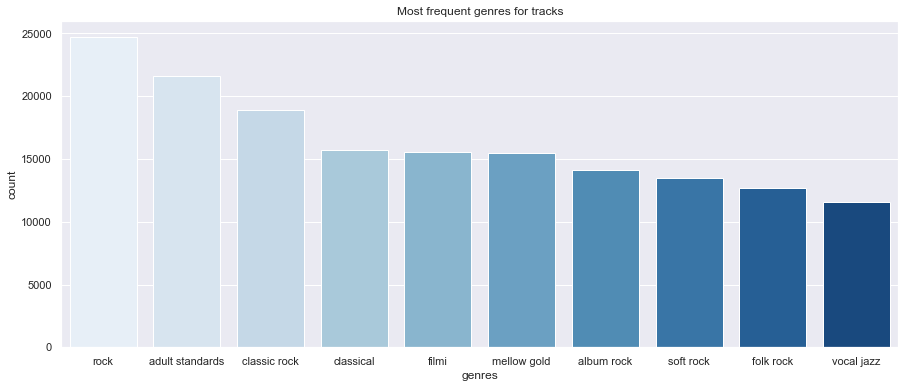

In [29]:
# When we merge the artists dataset with the tracks, do we still have missing values?
# how many tracks have a genre description?
empty_rows = merged_df[merged_df.astype(str)['genres'] == '[]']
perc_empty_g = empty_rows.shape[0] / merged_df.shape[0]
print('Percentage of genre entries for tracks dataset are empty: {:.2f} %'.format(perc_empty_g * 100))

exp_merged_df = merged_df.explode('genres')
exp_merged_df['genres'] = exp_merged_df['genres'].str.strip()
plt.figure(figsize=(15, 6))

sns.countplot(data=exp_merged_df, x='genres', palette="Blues", order=exp_merged_df['genres'].value_counts()[1:11].index) # itanic.deck.value_counts().iloc[:3].index)
plt.title('Most frequent genres for tracks')
plt.savefig('images/freq_genres.png')
plt.show()

 **Observations and Implications for Genres:**
* While for the artists dataset there seemed to be a lot of missing values, almost 98 % of the tracks contain genre information.
* The problems: There are 5366 categories of genres. Since genre is a categorical variable, the dataset would have way too many columns if I integrated them as dummy variables. Moreover, the genres describe the artist, not the track. There might be an artist who usually makes pop music but has one rock song. Now, the "rock" label would be on all the pop songs as well. 
* Idea: One could try to cluster the genres to reduce number of genres. This is time-consuming, so for now **I will not add the genre categories to the final model**. Maybe this could be done as a later extension of the project. Then, I should also take a closer look into the labels.

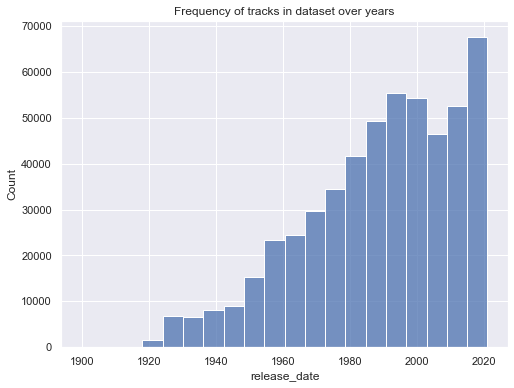

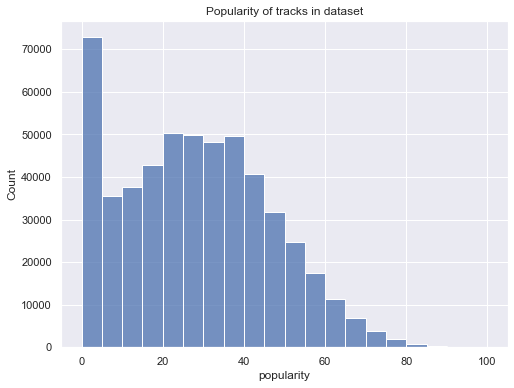

In [30]:
# Distribution of tracks over years
year = tracks['release_date'].dt.year
plt.figure(figsize=(8, 6))
sns.histplot(year, kde=False, bins=20)
plt.title('Frequency of tracks in dataset over years')
plt.savefig('images/freq_years.png')
plt.show()

# Distribution of popularity
plt.figure(figsize=(8, 6))
sns.histplot(tracks['popularity'], kde=False, bins=20)
plt.title('Popularity of tracks in dataset')
plt.savefig('images/popularity_tracks.png')
plt.show()

In [31]:
tracks['popularity'].mean()

27.485676306944416

In [32]:
tracks[tracks['popularity'] == 0].shape[0] / tracks.shape[0] * 100

7.559484248305197

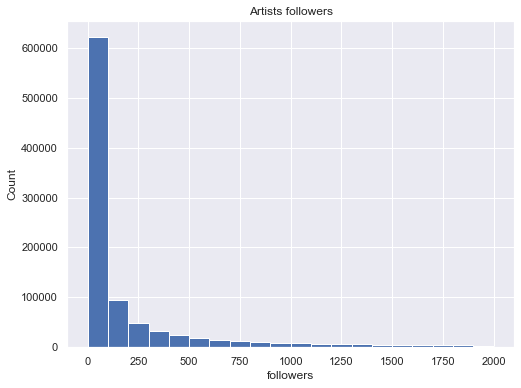

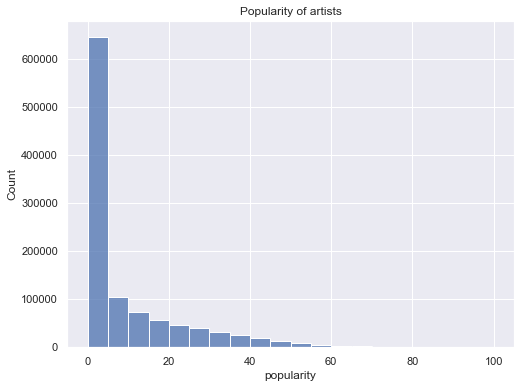

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(artists['followers'], bins=20, range=(0, 2000))
plt.title('Artists followers')
plt.xlabel('followers')
plt.ylabel('Count')
plt.savefig('images/followers_artists.png')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(artists['popularity'], bins=20)
plt.title('Popularity of artists')
plt.savefig('images/popularity_artists.png')
plt.show()

### Categorical Music-Related Features

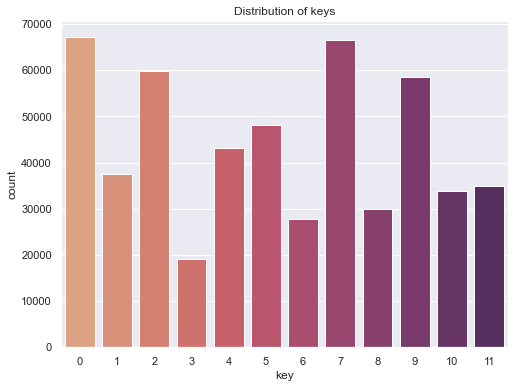

In [34]:
plt.figure(figsize=(8, 6))

sns.countplot(data=tracks, x='key', palette="flare")
plt.title('Distribution of keys')
plt.savefig('images/keys_count.png')
plt.show() 

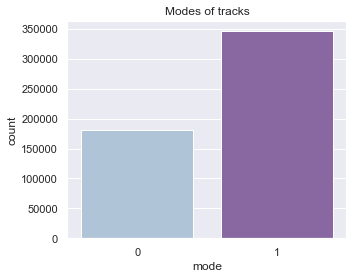

Ratio of modes: 65.73 % of songs are in Major, 34.27 % in Minor


In [35]:
num_elements = tracks.shape[0]

percentage_major = len(tracks[tracks['mode'] == 1])/ num_elements * 100
percentage_minor = len(tracks[tracks['mode'] == 0])/ num_elements * 100
plt.figure(figsize=(5, 4))
sns.countplot(data=tracks, x='mode', palette="BuPu")
plt.title('Modes of tracks')
plt.savefig('images/modes.png')
plt.show()
print('Ratio of modes: {:.2f} % of songs are in Major, {:.2f} % in Minor'.format(percentage_major, percentage_minor))

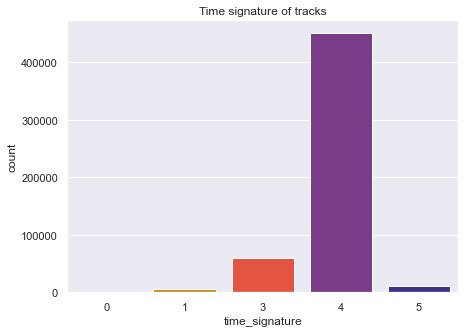

In [36]:
plt.figure(figsize=(7, 5))
sns.countplot(data=tracks, x='time_signature', palette="CMRmap_r")
plt.title('Time signature of tracks')
plt.savefig('images/time_signatures.png')
plt.show()

#### What does time signature = 0 mean?

In [37]:
tracks[tracks['time_signature'] == 0]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
817,2WTtJDfCUjAyCZHRSfCLDn,La Mina del Ford - Remasterizado,1,133947,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1924-03-29,0.0,0.025800,5,-24.894,1,0.0,0.996000,0.768,0.0831,0.0,0.0,0
1013,5tQsQaMquCXBREb1FNymi7,Oh Mujer Mujer - Remasterizado,0,170253,0,['Francisco Canaro'],['2maQMqxNnlRrBrS1oAsrX9'],1924-07-12,0.0,0.315000,8,-15.969,0,0.0,0.996000,0.956,0.3750,0.0,0.0,0
1043,6VweawuAyN9Ad9ikn9f5W3,Shangai Bay - Remasterizado,0,129027,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1924-03-29,0.0,0.082900,6,-24.272,1,0.0,0.996000,0.893,0.1230,0.0,0.0,0
1291,1JUFU8XJRWgG9Ir8KlLvpW,Pause Track,0,4000,0,['Louis Armstrong'],['19eLuQmk9aCobbVDHc6eek'],1925-01-01,0.0,0.000000,0,-60.000,0,0.0,0.000000,0.000,0.0000,0.0,0.0,0
6847,3KQ1c1UdSMnFgUO4MVbC2z,Chole Jay Mori Hay Basanter Din,0,183547,0,['Kanak Das Biswas'],['5ssATcDQpWpDOUnMHs1dXi'],1931-12-01,0.0,0.061800,6,-16.441,1,0.0,0.994000,0.724,0.2730,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586440,4THWkFVhSnDQzhh0khcVbp,Hidden Waterfall,33,422975,0,['White Noise Therapy'],['1O7bUkov2v71fDS60GOfMD'],2009-08-06,0.0,0.000020,11,-13.813,0,0.0,0.200000,1.000,0.3200,0.0,0.0,0
586506,2LsevvtdFSKb8ztwOvQXf0,Brown Noise,50,570654,0,['Brown Noise'],['4H1DT9A2uoT7pTVRDSolnk'],2013-03-21,0.0,0.000020,0,-16.517,1,0.0,0.119000,0.429,0.4670,0.0,0.0,0
586535,33wp91bmIk1XYn7aKxMone,Clean White Noise,37,72652,0,"['Spa', 'Spa, Relaxation and Dreams', 'Relax M...","['4LUYOHM73gVlfY5TzRbIgX', '2Kb4gv8jSstDI7ygRh...",2015-12-10,0.0,0.000020,9,-8.327,1,0.0,0.112000,0.331,0.6630,0.0,0.0,0
586536,2jhzrWv6ut9eieePWaYRC8,Spa Rain,45,97220,0,['Rain Sounds'],['5nSGBmlgUdqWNExnOX8VtV'],2015-12-14,0.0,0.007430,8,-19.901,1,0.0,0.000001,0.807,0.4140,0.0,0.0,0


The feature "time signature" is estimated, so for some of the songs, the time signature could not be estimated.
This is correct e.g. for tracks like "Spa Rain" but not correct for others (e.g. La Mina del Ford - Remasterizado). There is no quick fix for this since I would have to listen to 337 songs and it's correct for some tracks. Therefore I'll leave the tracks in the dataset for now but keep in mind that the feature "time signature" might not be so reliable.

**Observations and Implications:**  

* _release date_: The frequency of tracks increases over the years which makes sense since not everything from the early 20th century is available in digital format.
* _popularity_ : The largest group for track popularity is the one with lower popularity. When you compare it to artist popularity, the track popularity contains also higher values in the medium range. I don't have any information how popularity is measured which makes any interpretation difficult. It is only known that there is a scale from 0 to 100. If it is measured by likes and monthly listeners, it would mean that either some few songs / artists receive a huge amount of likes / monthly listeners in contrast to the majority of the other songs / artists which might skew the distribution or that most songs / artists in the dataset are not popular. which might skew the distribution. Without further information, it might not be useful to put these features into a model.
* _artist followers_: The distribution looks similar to the popularity, so the explanations apply here, too.
* _keys_: The keys C, D, G and A are used more often than the other keys which looks similar to what you might estimate from a classical music perspective: They are easier to play than the others. Especially D# / E-Flat seems to be an unpopular choice.
* _mode_: 2/3 of the tracks are in Major, 1/3 in Minor.
* _time signature_: The majority of the tracks is in a 4 time signature which is a popular choice in pop music. Some tracks have a time signature '0'. Taking a closer look, you see it is partly correct for noises but also partly wrong. As said above, it is better not to use this feature because there is no quick data cleaning step for this. It might not give us too much information anyway with most of the tracks having 4 as time signature and with the knowledge that time signatures might change for classical pieces.

### Exploration of Numerical Features

In [38]:
audio_ft = ['danceability', 'energy', 'loudness', 'speechiness', 
             'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

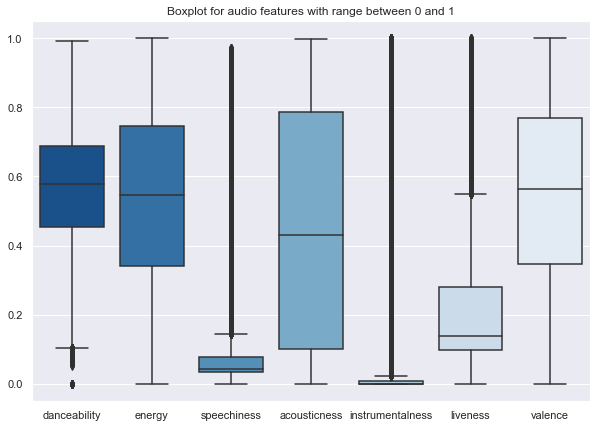

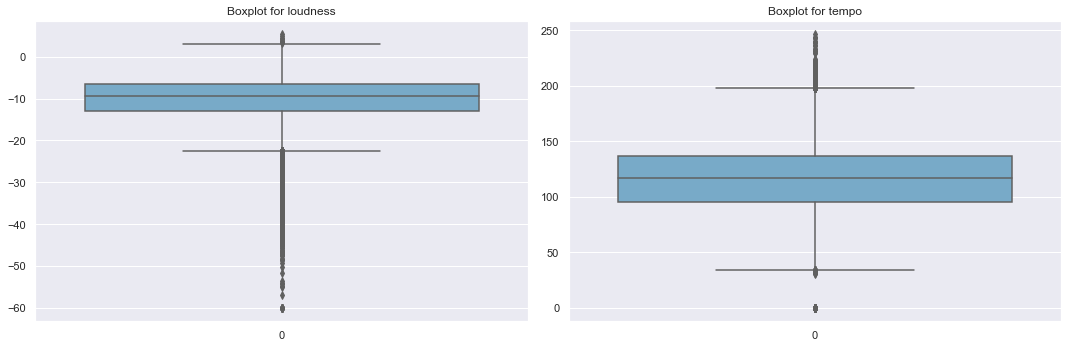

In [39]:
# boxplots for audio features, features with range [0, 1] can be shown in one figure 
plt.figure(figsize=(10, 7))
sns.boxplot(data=tracks.loc[:, audio_ft].drop(['loudness', 'tempo'], axis=1), palette='Blues_r') # BuPu_r
plt.title('Boxplot for audio features with range between 0 and 1')
plt.savefig('images/boxplot_audio_fts.png')
plt.show()

f, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
sns.boxplot(data=tracks.loc[:, 'loudness'], palette='Blues', ax=axes[0])
axes[0].set_title('Boxplot for loudness')
sns.boxplot(data=tracks.loc[:, 'tempo'], palette='Blues', ax=axes[1])
axes[1].set_title('Boxplot for tempo')
plt.savefig('images/boxplot_loud_tempo.png')
plt.tight_layout()

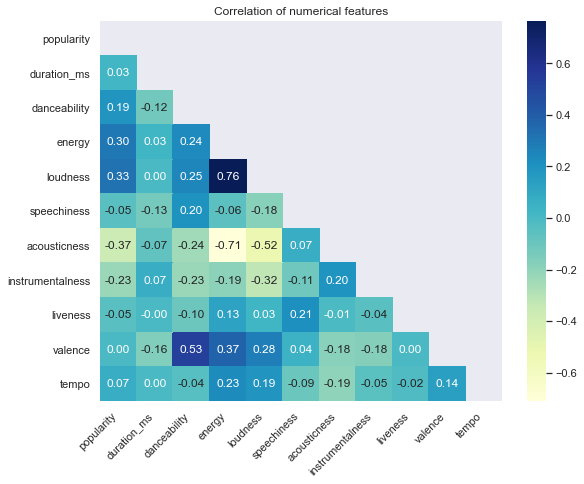

In [40]:
# correlation plot for numerical features
# drop categorical features
fts = tracks.drop(['id', 'name', 'artists', 'id_artists', 'release_date', 
                   'key', 'time_signature', 'mode', 'explicit'], 
                    axis=1)

corr = fts.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(9, 7))
ax = sns.heatmap(corr, annot=True, mask=mask, cmap="YlGnBu", fmt=".2f");
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
bottom, top = ax.get_ylim()
plt.title('Correlation of numerical features')
plt.savefig('images/corr.png')
plt.show()

**Observations and Implications:**  

**Boxplots:**
* Acousticness has the largest range between the bottom and top edge of the box. 
* Instrumentalness but also speechiness have a really low .75 percentile and a higher number of outliers. That means that their are similar for most of the tracks, so they might not be so important as features for the model. 
* For loudness and tempo, they mostly are distributed in a certain small range with a number of outliers.

**Correlations:**
* high positive correlation: energy - loudness, valence - danceability
* high negative correlation: acousticness - energy, acousticness - loudness

* The correlations imply some linear relations between some audio features, so I will remove "energy" from my features for the model. 

## Content-Based Recommendation for Songs

###  Create and Train Clustering Model for Parameters

**Choice of Features:** For clustering algorithms, categorical (binary) variables are difficult since the sample space for them is discrete while the distance metric expects a continuous space. For some algorithms, you could use a specific metric like the Gower distance. However, for that you will need to compute the distance matrix by yourself which costs too much memory for > 500 k rows. Therefore, I have to exclude the potentially categorical features for the recommendation algorithm and rely on the numerical features.

In [41]:
def get_model_columns(df):
    '''
    Drop categorical columns
    
    INPUT:
    df - dataframe with tracks columns
    
    OUTPUT:
    dataframe with reduced columns
    '''
    return df.drop(['id', 'name','explicit', 'artists', 'mode',
                    'id_artists', 'release_date', 'key',  'time_signature', 'duration_ms',  # 'mode_0', 'mode_1',
                    'popularity', 'energy'], axis=1) #  'popularity', 'mode_0', 'mode_1'

In [42]:
# create dataset for model

X = get_model_columns(tracks)

scaler = StandardScaler()
X = scaler.fit_transform(X)

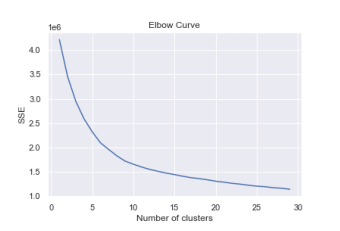

In [43]:
# only compute elbow if it wasn't computed before (long computation time)
if os.path.exists("images/kmeans_elbow.png"):
    image = img.imread("images/kmeans_elbow.png")
    imgplot = plt.imshow(image)
    plt.axis('off')
    plt.show()
else:

    sse = {}

    t0 = time.time()
    for k in range(1, 30):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100).fit(X)
        sse[k] = kmeans.inertia_
    t1 = time.time()
    diff = t1 - t0
    print('Computation time for elbow curve with 30 iterations: {:.2f} s'.format(diff))
    
    # Plotting the elbow curve
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title('Elbow Curve')
    # Save the Plot in current directory
    plt.savefig('images/kmeans_elbow.png')
    plt.show()

**Result Elbow:** Optimal k is _9_.

In [44]:
model = KMeans(
    n_clusters=9, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0, 
)
y_pred = model.fit_predict(X)

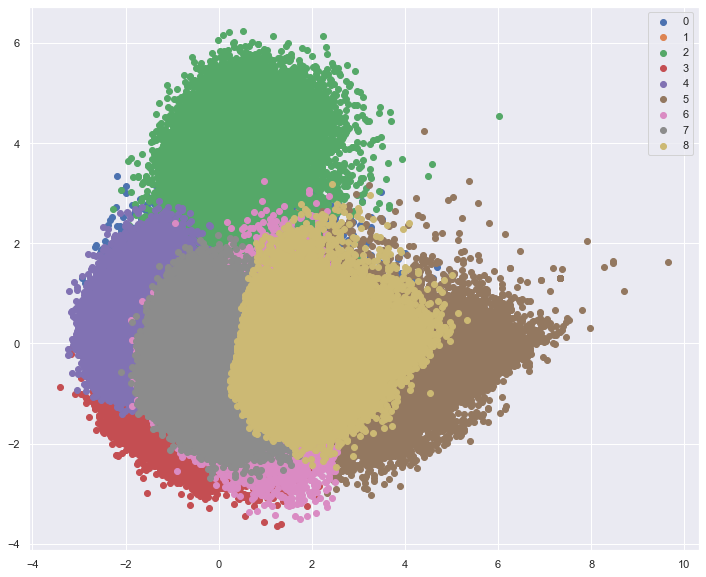

In [45]:
# reduce dimensions of data to 2 with PCA for visualization

pca = PCA(n_components=2)
X_transformed = pca.fit_transform(X)

X_red = pd.DataFrame(X_transformed)
X_red['label'] = y_pred

unique_labels = np.unique(y_pred)

plt.figure(figsize=(12,10))
for i in unique_labels:
    plt.scatter(X_red[X_red['label'] == i].iloc[:, 0], X_red[X_red['label'] == i].iloc[:, 1], label=i)
plt.legend()
plt.savefig('images/pca_clusters.png')
plt.show()

### Make Content-based Recommendation from User Input

* create song list and quickly explore some of their audio features
* build recommender
* apply song list

In [46]:
# create songlist for user X (since I don't have actual user data: assume as liked songs or playlist)
song_list = ['1yvMUkIOTeUNtNWlWRgANS', # Sia: Unstoppable
             '2kAgCRZPG3YQR2VMqRvLmb', # The Lark Ascending
             '5Gq57erX052FCaZsYD6HuH', # Egmont Overture, Beethoven
             '550rQQCGkrTzvp4SfpOPzx', # Pentatonix: Hallelujah
             '0TzbmxnYrlMV6dEln2l9nb', # MIKA: Happy Ending
             '3s4U7OHV7gnj42VV72eSZ6', # Clean Bandit, Jess Glynne: Rather Be
             '1TAC5SANfK7l6wGHtUQ7MX', # Caravan Palace: Lone Digger
             '260jSxvzkFt71ksvkcy2ke', # Avicii: Broken Arrows
             '78w7y8EDtL5LFaZ80rOkRl', # Humoresques No. 7, Dvorak 
             '1ZI4QTZV4gghrbEPlG3VAV', # Violin Concerto in D, Tchaikovsky
            ]

#### Short Exploration of the User Songs

In [47]:
# get features
user_songs = tracks[tracks['id'].isin(song_list)]
user_songs

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
30050,1ZI4QTZV4gghrbEPlG3VAV,"Violin Concerto in D Major, Op. 35: I. Allegro...",20,951613,0,"['Pyotr Ilyich Tchaikovsky', 'Jascha Heifetz',...","['3MKCzCnpzw3TjUYs2v7vDA', '7yaBUcdjmqPP2vIv6F...",1956-01-01,0.3720,0.1730,2,-17.512,1,0.0427,0.8710,0.038400,0.0882,0.1750,110.165,4
36487,5Gq57erX052FCaZsYD6HuH,"Egmont, Op. 84: Overture",20,514133,0,"['Ludwig van Beethoven', 'George Szell', 'Clev...","['2wOqMjp9TyABvtHdOSOTUS', '2CFaOiHKik5FgNGzZJ...",1962-01-01,0.2660,0.1130,8,-17.449,1,0.0425,0.9260,0.679000,0.1140,0.0942,83.076,3
67745,78w7y8EDtL5LFaZ80rOkRl,"8 Humoresques, Op. 101, B. 187: No. 7, Poco le...",57,212360,0,"['Antonín Dvořák', 'Seiji Ozawa', 'Yo-Yo Ma', ...","['6n7nd5iceYpXVwcx8VPpxF', '0atCvjK2GL6ezQFGOQ...",1994-01-01,0.1820,0.0603,6,-25.046,1,0.0459,0.8520,0.411000,0.1450,0.1410,98.799,4
80657,0TzbmxnYrlMV6dEln2l9nb,Happy Ending,64,273800,0,['MIKA'],['5MmVJVhhYKQ86izuGHzJYA'],2007-01-01,0.5640,0.4370,1,-8.375,1,0.0285,0.5520,0.000000,0.2170,0.3070,96.018,4
86644,2kAgCRZPG3YQR2VMqRvLmb,The Lark Ascending,65,935360,0,"['Ralph Vaughan Williams', 'Tasmin Little', 'B...","['7wNkISK49lKeXuRaZcQVFe', '0yB2SgzCCYb9uhjd4B...",2013-01-01,0.0811,0.0122,4,-32.654,0,0.0511,0.9020,0.308000,0.0648,0.0384,74.554,4
87092,3s4U7OHV7gnj42VV72eSZ6,Rather Be (feat. Jess Glynne),75,227833,0,"['Clean Bandit', 'Jess Glynne']","['6MDME20pz9RveH9rEXvrOM', '4ScCswdRlyA23odg9t...",2014-01-17,0.7990,0.5860,11,-6.735,1,0.0377,0.1620,0.000002,0.1930,0.5490,120.970,4
89082,1yvMUkIOTeUNtNWlWRgANS,Unstoppable,75,217747,0,['Sia'],['5WUlDfRSoLAfcVSX1WnrxN'],2016-10-21,0.4680,0.7790,9,-4.839,1,0.0779,0.1120,0.000373,0.1010,0.2600,173.799,4
89879,550rQQCGkrTzvp4SfpOPzx,Hallelujah,66,268960,0,['Pentatonix'],['26AHtbjWKiwYzsoGoUZq53'],2016-10-21,0.3220,0.3770,7,-7.385,0,0.0356,0.4540,0.000000,0.3380,0.3660,118.669,4
114128,1TAC5SANfK7l6wGHtUQ7MX,Lone Digger,60,229805,0,['Caravan Palace'],['37J1PlAkhRK7yrZUtqaUpQ'],2015-10-16,0.7670,0.9380,5,-4.433,0,0.0505,0.5920,0.019300,0.1180,0.8680,123.992,4
238157,260jSxvzkFt71ksvkcy2ke,Broken Arrows,63,232760,0,['Avicii'],['1vCWHaC5f2uS3yhpwWbIA6'],2015-10-02,0.6300,0.6660,7,-7.186,1,0.0450,0.0481,0.000567,0.1040,0.2880,115.973,4


In [48]:
# use list
songs_fts = get_model_columns(user_songs) 
songs_fts.describe()

,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,10.000000,10.000000,10.00000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,0.445110,-13.161400,0.04574,0.54711,0.145664,0.148300,0.308660,111.601500
std,0.243129,9.645057,0.01321,0.34395,0.239094,0.081373,0.245338,27.434602
min,0.081100,-32.654000,0.02850,0.04810,0.000000,0.064800,0.038400,74.554000
25%,0.280000,-17.496250,0.03890,0.23500,0.000095,0.101750,0.149500,96.713250
50%,0.420000,-7.880000,0.04385,0.57200,0.009934,0.116000,0.274000,113.069000
75%,0.613500,-6.847750,0.04935,0.86625,0.240600,0.181000,0.351250,120.394750
max,0.799000,-4.433000,0.07790,0.92600,0.679000,0.338000,0.868000,173.799000


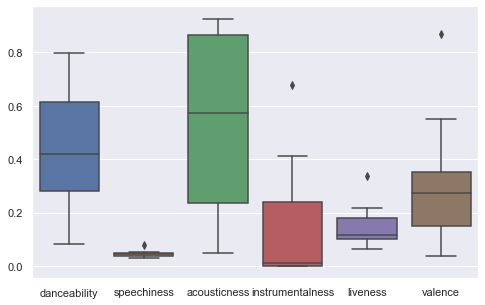

In [49]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=songs_fts.drop(['loudness', 'tempo'], axis=1))
plt.show()

**Observation:** quite a high range, so we shouldn't just take the mean values

In [50]:
def get_frequent_clusters(predictions, top_n):
    ''' Get frequent clusters based on the predictions (labels)
    
    INPUT:
    predictions - array with predictions
    top_n - how many cluster classes should be used
    
    OUTPUT:
    number of clusters - top_n except the unique values are less
    clusters sorted by frequency restricted to cluster_num clusters
    percentage of cluster classes in aray
    '''
    unique_values, frequency = np.unique(predictions, return_counts=True)
    cluster_num = min(top_n, unique_values.shape[0])
    
    # get most frequent clusters
    sorted_indexes = np.argsort(frequency)[::-1]

    frequent_clusters = unique_values[sorted_indexes]
    sorted_freq = frequency[sorted_indexes]
    freq_sum = np.sum(sorted_freq[:cluster_num]) # only take sum for cluster_num 
    # To what percentage should cluster x be used for the recommendation?
    freq_perc = [(i / freq_sum) for i in sorted_freq[:cluster_num]]
    return cluster_num, frequent_clusters, freq_perc

In [51]:
def make_recommendations(df, all_data, scaler, model, rec_max=5, top_n=3):
    ''' Make content-based recommendation with the help of the cluster
    
    INPUT: 
    df - user input dataframe
    all_data - tracks data
    scaler - fitted scaler
    model - clustering model
    rec_max - how many recommendations should be mad
    top_n - how many cluster classes should be used
    
    OUPUT:
    dataframe with columns id and similarity - contains most similar ids for the respective class
    
    '''
    # transform data and make cluster predictions
    song_ids = df['id'].values.tolist()
    X = get_model_columns(df)
    
    data = get_model_columns(all_data)
    data = scaler.transform(data)
    
    transformed_X = scaler.transform(X)
    predictions = model.predict(transformed_X)
    print('Prediction of cluster classes: ', predictions)
    
    # determine the most frequent cluster classes from user input 
    # dependent on the frequency it is decided how many recommendations come from the respective classes
    # e.g. 20 % of predictions is class 3: .2 * rec_max recommendations are done with user items with class prediction 3 
    cluster_num, frequent_clusters, freq_perc = get_frequent_clusters(predictions, top_n)
        
    recs_id = pd.DataFrame(columns=['id', 'similarity'])
    recs = pd.DataFrame(columns=all_data.columns)
    for i in range(cluster_num):
        # determine number of recommendations
        rec_num = round(freq_perc[i] * rec_max)
        cluster_number = frequent_clusters[i]

        # make mean vector out of songs from cluster - best idea?
        # find position of elements from cluster
        pos = np.where(predictions == cluster_number)[0] 
        cluster_songs = transformed_X[pos, :]

        mean_song = np.mean(cluster_songs, axis=0)
        
        # make rec_num recommendations using cluster_num

        # calculate similarity
        similarity = cdist(np.reshape(mean_song, (1,-1)), data)
        
        # sort, but keep id in mind
        similarity_s = pd.Series(similarity.flatten(), name='similarity')
        similar_songs = pd.concat([all_data['id'].reset_index(drop=True), similarity_s.reset_index(drop=True)], axis=1)
        
        # remove songs from user_songs list
        similar_songs = similar_songs[~(similar_songs['id'].isin(song_ids))]
        similar_songs = similar_songs.sort_values(by='similarity', ascending=True).reset_index(drop=True)
        
        recs_id = recs_id.append(similar_songs)
        
    recs_id = recs_id.reset_index(drop=True)
    
    return recs_id.loc[:rec_max-1]

In [52]:
recs = make_recommendations(user_songs, tracks, scaler, model)
rec_ids = list(recs['id'])
recommendations = tracks[tracks['id'].isin(rec_ids)]
recommendations

Prediction of cluster classes:  [8 5 5 7 5 4 3 7 4 7]


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
228779,3MoFlSJVo0c2NoTXhWmbyE,תפוזים,21,170320,0,['Yoni Bloch'],['3gC0JIIgE2lK3yztam5ndm'],2004-03-18,0.479,0.522,2,-6.983,1,0.0397,0.306,0.000001,0.219,0.320,111.530,4
248488,23jMDvKil4frbTA35BVzBY,El Anillo del Capitán Beto,49,306627,0,['Invisible'],['3FjdJbt6Myq32uv7P4owM1'],1976-05-27,0.487,0.511,9,-8.549,1,0.0403,0.311,0.000000,0.198,0.292,105.716,4
404838,1MvFYNOT0wJzUHV9v5pHoT,Dalam Diam Aku Mencintaimu,41,356960,0,['Stings'],['3fmwpWRwGkgVkXTqsygeyr'],2009-01-01,0.492,0.650,1,-7.272,1,0.0283,0.387,0.000032,0.192,0.390,104.541,4
480340,1x5amtsRoj0cByTekLTUma,Para Darte Amor,6,182960,0,['Nuevas Raíces'],['5TCwyQfcbNbAGS6TtERiJT'],1995-09-17,0.506,0.551,8,-8.355,1,0.0287,0.384,0.000847,0.197,0.319,120.037,3
489234,7pYDn4ArQQNkytr98kEvMc,Ni Tú Ni Yo,6,274390,0,['Rudy Marquez'],['40KS6MHytlDIWwQQwbfETj'],1977-01-01,0.501,0.487,2,-8.497,0,0.0306,0.287,0.000472,0.188,0.341,106.320,4


### Discussion of the Results

#### K-Means Clustering
As mentioned above, after trying out a clustering algorithm with the Gower distance (memory eror) and a variation of K-Means that can handle categorical data (KPrototypes, trained for several hours, results not better than K-Means), I decided to exclude the categorical data for now and only use numerical data for the model.   
The most important hyperparameter for K-Means is the number of clusters k. I optimized this parameter with the commonly used Elbow method. Nevertheless, the K-Means model SSE is quite high. This should be improved by varying more hyperparameters or even trying other clustering algorithms.

#### Recommender System

What is difficult with recommender systems is that there is no direct evaluation possibility. In reality, you would test it in a user study which is not possible for such an example project without a high number of users. I can listen to the songs and say whether I like them but this is of course not a real evaluation. 
What I found difficult was the question to what I should calculate the distance to. If I take each song one by one and calculate the similarity to the rest, I will end up only using the first tracks from the user list to make the recommendations instead of using as much information I have from the user. Calculating a mean song out of all user songs would also make me loose a lot of information and I might end up in a "corner" of the dataset with songs the user doesn't like at all. That's why I created the clustering algorithm to do something in between: I'm still calculating a mean vector but only for tracks from one class. I'm sure there are other ways to do it which in my opinion would require a deeper understanding of the audio features (e.g. what are better alternatives to using the mean).

To really be useful, a Web API should be added so that a user could search for songs to create a user list more conveniently. There should be a connection to the Spotify Web API which provides the necessary audio features so that the user list could also contain tracks that are not available in our dataset. 